In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
class person:
    def __init__(self,
                 name,
                 config
                ):
        self.name = name
        
        if config['type']=='manual':
            assert max(config['personality'])<=1 and min(config['personality'])>=0, "all dimensions of personality should be between 0 and 1"
            assert max(config['impressionability'])<=1 and min(config['impressionability'])>=0, "all dimensions of impressionability should be between 0 and 1"
            
            self.personality = config['personality']
            self.impressionability = config['impressionability']
            
        elif config['type']=='random':
            self.personality = 2*config['rng'].beta(config['pers_a'],config['pers_b'],size=config['personality_dim']) - 1
            self.impressionability = config['rng'].beta(config['impr_a'],config['impr_b'],size=config['personality_dim'])
        
        else:
            raise Exception("config_type can only be manual or random")
            
        
    def develop_personality(self,update_v):
        self.personality = np.clip((1-self.impressionability)*self.personality + self.impressionability*update_v,-1,1)
        

In [3]:
rng = np.random.default_rng()

In [4]:
random_config_1 = {'type':'random','rng':rng,'pers_a':0.7,'pers_b':0.7,'impr_a':0.3,'impr_b':1,'personality_dim':4}

In [5]:
p1 = person('1',random_config_1)
p2 = person('2',random_config_1)

In [6]:
p1.personality,p1.impressionability

(array([ 0.31013451,  0.13725194, -0.42570614, -0.4465121 ]),
 array([0.21219594, 0.06721085, 0.02090854, 0.02943082]))

In [7]:
p2.personality,p2.impressionability

(array([-0.22982391, -0.67368089,  0.47498809, -0.82268489]),
 array([0.96557572, 0.0404615 , 0.00820696, 0.12374896]))

In [8]:
np.linalg.norm(p1.personality),np.linalg.norm(p2.personality)

(0.7040030417299984, 1.1870505799481006)

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-5*x))

In [10]:
sigmoid(-1)

0.0066928509242848554

In [11]:
np.dot(p1.personality,p2.personality),sigmoid(np.dot(p1.personality,p2.personality))

(0.001393075567052704, 0.5017413374185234)

In [12]:
p1.develop_personality(p2.personality)

In [13]:
pers_array = np.zeros((2,4))

In [14]:
pers_array[0,:] = p1.personality
pers_array[1,:] = p2.personality

In [15]:
pers_array

array([[ 0.19555752,  0.08274846, -0.40687394, -0.45758318],
       [-0.22982391, -0.67368089,  0.47498809, -0.82268489]])

In [16]:
np.linalg.norm(p1.personality)**2

0.42001881384034756

In [17]:
bonds = sigmoid(np.matmul(pers_array,p1.personality))

In [18]:
bonds[0] = 0

In [19]:
bonds


array([0.        , 0.60168316])

In [20]:
(bonds.reshape((2,1))*pers_array).sum(axis=0)/bonds.sum()

array([-0.22982391, -0.67368089,  0.47498809, -0.82268489])

In [21]:
p1.impressionability

array([0.21219594, 0.06721085, 0.02090854, 0.02943082])

In [22]:
p1.personality

array([ 0.19555752,  0.08274846, -0.40687394, -0.45758318])

In [23]:
p1.develop_personality((bonds.reshape((2,1))*pers_array).sum(axis=0)/bonds.sum())

In [24]:
p1.personality

array([ 0.10529331,  0.0319082 , -0.38843548, -0.46832842])

In [154]:
class group:
    def __init__(self,
                 person_config,pop_size,rng,independence=5,learning_rate=0.01
                ):
        
        self.independence=independence
        ppl = {}
        for i in range(pop_size):
            ppl[i] = person(i,person_config)
            
        self.people=ppl
        self.pop_size=pop_size
        self.learning_rate=learning_rate
        
        self.pers_array = np.zeros((pop_size,person_config['personality_dim']))
        for n,p in ppl.items():
            self.pers_array[n,:] = p.personality
            
        self.impr_array = np.zeros((pop_size,person_config['personality_dim']))
        for n,p in ppl.items():
            self.impr_array[n,:] = p.impressionability
        
        self.bonds = self.sigmoid(np.matmul(self.pers_array,self.pers_array.T))
        
        self.pers_array_history=[copy.deepcopy(self.pers_array)]
        self.bonds_history=[copy.deepcopy(self.bonds)]
            
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-self.independence*x))    
        
        
    def interact(self):
        update_vs = []
#         for n,p in self.people.items():
#             bonds = self.sigmoid(np.matmul(self.pers_array,p.personality)).reshape((self.pop_size,1))
#             bonds[n] = 0
#             update_v = (bonds*self.pers_array).sum(axis=0)/bonds.sum()
#             update_vs.append(update_v)
        
#         print(update_vs)
#         self.bonds = self.sigmoid(np.matmul(self.pers_array,self.pers_array.T))
        self.bonds = np.matmul(self.pers_array,self.pers_array.T)
        np.fill_diagonal(self.bonds,0)
        self.bonds_history.append(copy.deepcopy(self.bonds))
        
        update_vs = np.matmul(self.bonds,self.pers_array)/self.bonds.sum(axis=1,keepdims=True)
        
        for n,p in self.people.items():
            p.develop_personality(self.learning_rate*update_vs[n])
            self.pers_array[n,:] = p.personality
        
        
    
        self.pers_array_history.append(copy.deepcopy(self.pers_array))
        
    def set_impr_array(self,impr_array_new):
        self.impr_array=copy.deepcopy(impr_array_new)
        for n,p in self.people.items():
            p.impressionability = copy.deepcopy(impr_array_new[n,:])
            
    def set_pers_array(self,pers_array_new):
        self.pers_array=copy.deepcopy(pers_array_new)
        for n,p in self.people.items():
            p.personality = copy.deepcopy(pers_array_new[n,:])
            
        self.bonds = self.sigmoid(np.matmul(self.pers_array,self.pers_array.T))
        
        self.pers_array_history=[copy.deepcopy(self.pers_array)]
        self.bonds_history=[copy.deepcopy(self.bonds)]
            
    def run_sim(self,num_iter,verbose=False):
        print("Beginning simulation. Will run for {} iterations".format(num_iter))
        print("Initial pers_array:")
        print(self.pers_array)
        for i in range(num_iter):
            self.interact()
            if verbose:
                print("pers_array after iteration {}:".format(i))
                print(self.pers_array)
        print("pers_array after simulation for {} iterations:".format(i))
        print(self.pers_array)

In [26]:
random_config_1 = {'type':'random','rng':rng,'pers_a':0.7,'pers_b':0.7,'impr_a':0.3,'impr_b':1,'personality_dim':10}
grp_1 = group(random_config_1,10,rng,independence=1,learning_rate=1)

In [27]:
grp_1.run_sim(10000)

Beginning simulation. Will run for 10000 iterations
Initial pers_array:
[[ 0.90630177  0.89211541 -0.8496438   0.08135969  0.95795733  0.54832488
  -0.97844014  0.30989672 -0.14577154  0.5950439 ]
 [ 0.65880686  0.33942382 -0.73988303 -0.96296926 -0.44038162 -0.45088577
  -0.29516345 -0.32613284 -0.1643317   0.14747146]
 [-0.87869898  0.47097666  0.7996371   0.55483875  0.81794014  0.944168
   0.36344269  0.49178348 -0.00859855 -0.86407743]
 [-0.99932646  0.12578504  0.75433012  0.30032882 -0.97499849  0.98879816
  -0.08051809 -0.15683843  0.49594088  0.80008948]
 [ 0.81764046  0.80602581  0.58292737 -0.91859443 -0.96701723  0.63452647
   0.88000668  0.41998646 -0.63167984  0.48857347]
 [ 0.65380717  0.65525836  0.97491043  0.53311088 -0.89107357 -0.19048018
  -0.45804452  0.60159085  0.97727072 -0.40739499]
 [ 0.99178328  0.58605878  0.34476513  0.16781094  0.53814383  0.53539188
  -0.8365071  -0.27268351 -0.51453627  0.97798153]
 [ 0.89834613  0.7679516   0.1700529  -0.03088882 -0.95

In [28]:
pers_array_hist_1 = np.array(grp_1.pers_array_history)

In [29]:
pers_array_hist_1.shape

(10001, 10, 10)

In [30]:
# pers_array_hist_1[:,0,:]

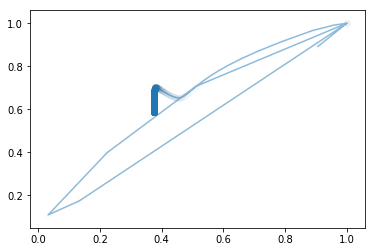

In [31]:
pers_idx=0
plt.scatter(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.5)

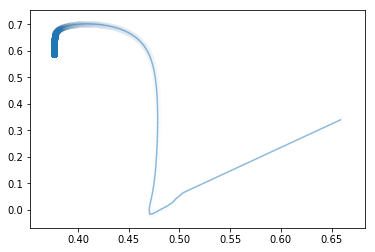

In [32]:
pers_idx=1
plt.scatter(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.5)

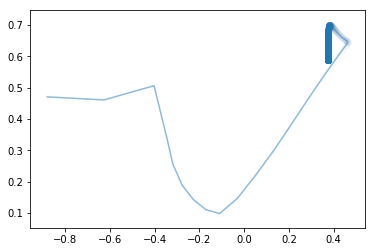

In [33]:
pers_idx=2
plt.scatter(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.5)

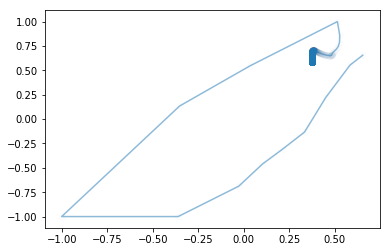

In [34]:
pers_idx=5
plt.scatter(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_1[:,pers_idx,0],pers_array_hist_1[:,pers_idx,1],alpha=0.5)

In [35]:
pers_array_hist_1[0,:,:].mean(axis=0)

array([ 0.44000161,  0.43010651,  0.27190637, -0.02674449, -0.34138657,
        0.4083775 ,  0.03601856,  0.04801178,  0.06139602,  0.15680779])

In [36]:
pers_array_hist_1[10000,:,:]

array([[ 0.37664083,  0.58803277,  0.26712264, -0.64490957, -0.87718624,
         0.92615898,  0.36280178, -0.13422149, -0.02109307, -0.99946479],
       [ 0.37664083,  0.58803277,  0.26712264, -0.64488389, -0.87711795,
         0.92615995,  0.36280178, -0.13421802, -0.02109275, -0.99946439],
       [ 0.37664083,  0.58803277,  0.26712264, -0.64490331, -0.87718399,
         0.92639607,  0.36280178, -0.13418114, -0.02109304, -0.99932122],
       [ 0.37664083,  0.58803277,  0.26712264, -0.64489715, -0.87718766,
         0.92615975,  0.36280178, -0.13421797, -0.02109317, -0.99946455],
       [ 0.37664083,  0.58803277,  0.26712264, -0.72946889, -0.87717733,
         0.92614303,  0.36280178, -0.13422059, -0.02109315, -0.99946469],
       [ 0.37664083,  0.58803277,  0.26712264, -0.64388132, -0.89106393,
         0.92597892,  0.36280178, -0.13421967, -0.0210903 , -0.99946424],
       [ 0.37664083,  0.58803277,  0.26712264, -0.56124912, -0.8744706 ,
         0.92612607,  0.36280178, -0.1342215 

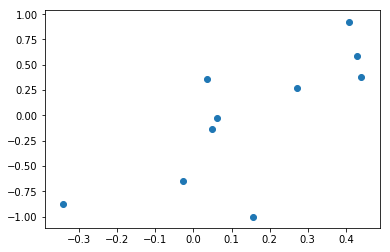

In [37]:
plt.scatter(pers_array_hist_1[0,:,:].mean(axis=0),pers_array_hist_1[10000,2,:])

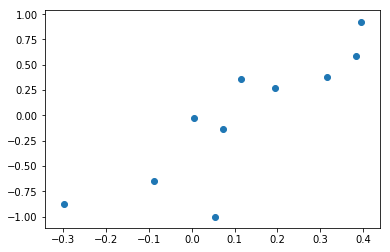

In [38]:
plt.scatter(((np.ones(grp_1.impr_array.shape) - grp_1.impr_array) * pers_array_hist_1[0,:,:]).mean(axis=0),pers_array_hist_1[10000,2,:])

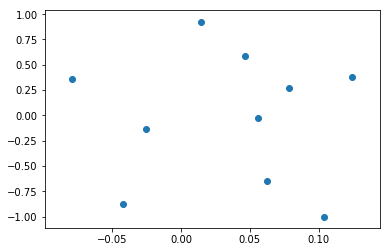

In [39]:
plt.scatter((grp_1.impr_array * pers_array_hist_1[0,:,:]).mean(axis=0),pers_array_hist_1[10000,2,:])

In [40]:
grp_1.bonds_history[0]

array([[0.99325923, 0.74659118, 0.39524468, 0.20297465, 0.49089287,
        0.42160903, 0.96585558, 0.3789797 , 0.35068147, 0.25760484],
       [0.74659118, 0.93483469, 0.06153982, 0.2029354 , 0.76574299,
        0.40493957, 0.62758269, 0.80836306, 0.69030823, 0.25355482],
       [0.39524468, 0.06153982, 0.99026573, 0.73909626, 0.38589422,
        0.59237299, 0.36360629, 0.1704357 , 0.66953154, 0.32493985],
       [0.20297465, 0.2029354 , 0.73909626, 0.98921987, 0.72298056,
        0.7514314 , 0.50879579, 0.32836449, 0.48483486, 0.94196552],
       [0.49089287, 0.76574299, 0.38589422, 0.72298056, 0.99562778,
        0.71409483, 0.75056581, 0.94570955, 0.96686217, 0.59043882],
       [0.42160903, 0.40493957, 0.59237299, 0.7514314 , 0.71409483,
        0.99019029, 0.54844064, 0.78096777, 0.8993617 , 0.64286657],
       [0.96585558, 0.62758269, 0.36360629, 0.50879579, 0.75056581,
        0.54844064, 0.98280279, 0.58692968, 0.27822749, 0.69686139],
       [0.3789797 , 0.80836306, 0.1704357

In [41]:
grp_1.bonds_history[100]

array([[0.        , 2.31530307, 2.66113851, 2.27766795, 2.6680038 ,
        1.53287173, 1.39141083, 2.52207985, 2.70524601, 1.96491506],
       [2.31530307, 0.        , 2.57892317, 2.24464197, 2.62527467,
        1.59665787, 1.33691722, 2.49500843, 2.66267511, 1.92237265],
       [2.66113851, 2.57892317, 0.        , 2.57446943, 2.98003815,
        1.76727671, 1.64847495, 2.75106886, 3.0465821 , 2.21674491],
       [2.27766795, 2.24464197, 2.57446943, 0.        , 2.58067253,
        1.67891367, 1.2359599 , 2.46728309, 2.63913135, 1.90624012],
       [2.6680038 , 2.62527467, 2.98003815, 2.58067253, 0.        ,
        1.76718095, 1.36876347, 2.84940549, 3.13526122, 2.29309103],
       [1.53287173, 1.59665787, 1.76727671, 1.67891367, 1.76718095,
        0.        , 0.37821564, 1.97186472, 1.89020734, 1.360818  ],
       [1.39141083, 1.33691722, 1.64847495, 1.2359599 , 1.36876347,
        0.37821564, 0.        , 1.11850267, 1.47555592, 0.84986229],
       [2.52207985, 2.49500843, 2.7510688

### Trying to see if copies lead to the same solution 
Is the system chaotic?

In [155]:
grp_2 = group(random_config_1,10,rng,independence=1,learning_rate=1)

In [156]:
grp_2_1 = copy.deepcopy(grp_2)

In [157]:
grp_2_1.run_sim(10000)

Beginning simulation. Will run for 10000 iterations
Initial pers_array:
[[-0.84574793  0.35559542 -0.49707963  0.97538428 -0.72831058  0.21093904
   0.07938885 -0.01498696 -0.68097059  0.62111142]
 [-0.51476335  0.48996309 -0.1360283  -0.99789698  0.71906689  0.6710591
   0.97054976 -0.43170347  0.99075511 -0.65232223]
 [ 0.65369986 -0.55311934 -0.46562595  0.14082283 -0.7526724  -0.64544297
   0.33064829 -0.80159568 -0.67702598 -0.98425191]
 [-0.00673264 -0.9115931  -0.01801027 -0.98423611  0.40524453  0.37700294
  -0.15006108 -0.08192715 -0.9851877   0.61622234]
 [ 0.63388208  0.85580935  0.4035271   0.97445326 -0.81408533 -0.37156446
   0.09101095 -0.04440875 -0.75813997 -0.11274998]
 [ 0.69304786 -0.34732693 -0.5658845  -0.30648963  0.94306425  0.95192649
  -0.53256355 -0.32385035  0.99593154 -0.37470854]
 [-0.87714512  0.04145023 -0.85825443  0.41318476  0.49642844 -0.9504982
  -0.24444171 -0.43538884 -0.7246472   0.34512675]
 [-0.05569839 -0.34362505  0.95308017 -0.35088944  0.95

In [158]:
pers_array_hist_2_1 = np.array(grp_2_1.pers_array_history)

In [159]:
pers_array_hist_2_1.shape

(10001, 10, 10)

In [160]:
# grp_2_2 = copy.deepcopy(grp_2)
grp_2_2 = group(random_config_1,10,rng,independence=1,learning_rate=1)

In [161]:
# grp_2_2.impr_array = copy.deepcopy(grp_1.impr_array)
grp_2_2.set_impr_array(copy.deepcopy(grp_2.impr_array))
grp_2_2.set_pers_array(copy.deepcopy(grp_2.pers_array))

In [162]:
grp_2_2.run_sim(10000)

Beginning simulation. Will run for 10000 iterations
Initial pers_array:
[[-0.84574793  0.35559542 -0.49707963  0.97538428 -0.72831058  0.21093904
   0.07938885 -0.01498696 -0.68097059  0.62111142]
 [-0.51476335  0.48996309 -0.1360283  -0.99789698  0.71906689  0.6710591
   0.97054976 -0.43170347  0.99075511 -0.65232223]
 [ 0.65369986 -0.55311934 -0.46562595  0.14082283 -0.7526724  -0.64544297
   0.33064829 -0.80159568 -0.67702598 -0.98425191]
 [-0.00673264 -0.9115931  -0.01801027 -0.98423611  0.40524453  0.37700294
  -0.15006108 -0.08192715 -0.9851877   0.61622234]
 [ 0.63388208  0.85580935  0.4035271   0.97445326 -0.81408533 -0.37156446
   0.09101095 -0.04440875 -0.75813997 -0.11274998]
 [ 0.69304786 -0.34732693 -0.5658845  -0.30648963  0.94306425  0.95192649
  -0.53256355 -0.32385035  0.99593154 -0.37470854]
 [-0.87714512  0.04145023 -0.85825443  0.41318476  0.49642844 -0.9504982
  -0.24444171 -0.43538884 -0.7246472   0.34512675]
 [-0.05569839 -0.34362505  0.95308017 -0.35088944  0.95

In [186]:
grp_2_2.run_sim(20000)

Beginning simulation. Will run for 20000 iterations
Initial pers_array:
[[ 0.30030924 -0.17767439  0.91082138  0.92371632  0.43975066 -0.27514931
  -0.50125681 -0.04380633  0.81542303  0.51620995]
 [ 0.29997672 -0.17767439  0.91082333  0.92371632  0.65735503 -0.27514931
  -0.50125681 -0.04343453  0.81542354  0.51620995]
 [ 0.3002456  -0.17767439  0.91082153  0.92371632  0.43969426 -0.27514931
  -0.50125681 -0.04380846  0.81542303  0.51620995]
 [ 0.30045262 -0.17767439  0.91082103  0.92371632  0.39780186 -0.27514931
  -0.50125681 -0.05130795  0.81542303  0.51620995]
 [ 0.63143941 -0.17767439  0.91074015  0.92371632  0.27314544 -0.27514931
  -0.50125681 -0.04377996  0.81542304  0.51620995]
 [ 0.30040067 -0.17767439  0.91082304  0.92371632  0.42506984 -0.27514931
  -0.50125681 -0.0437799   0.81542303  0.51620995]
 [ 0.30020552 -0.17767439  0.91096096  0.92371632  0.43975419 -0.27514931
  -0.50125681 -0.04329125  0.81542303  0.51620995]
 [-0.04103246 -0.17767439  0.93465054  0.92371632  0.

In [183]:
pers_array_hist_2_2 = np.array(grp_2_2.pers_array_history)

In [184]:
pers_array_hist_2_2.shape

(30001, 10, 10)

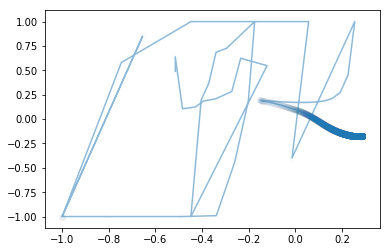

In [165]:
pers_idx=1
plt.scatter(pers_array_hist_2_1[:,pers_idx,0],pers_array_hist_2_1[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_2_1[:,pers_idx,0],pers_array_hist_2_1[:,pers_idx,1],alpha=0.5)

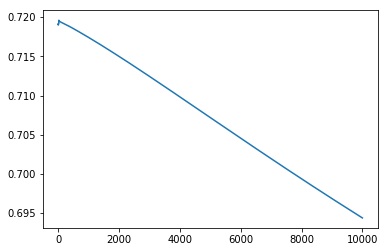

In [181]:
pers_idx=1
plt.plot(pers_array_hist_2_1[:,pers_idx,4])

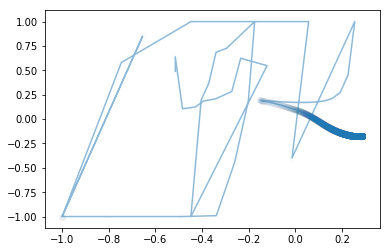

In [167]:
pers_idx=1
plt.scatter(pers_array_hist_2_2[:,pers_idx,0],pers_array_hist_2_2[:,pers_idx,1],alpha=0.01)
plt.plot(pers_array_hist_2_2[:,pers_idx,0],pers_array_hist_2_2[:,pers_idx,1],alpha=0.5)

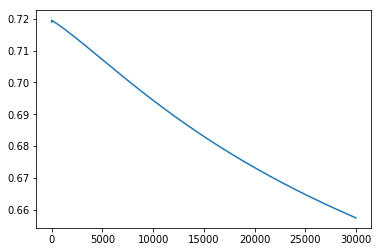

In [185]:
pers_idx=1
plt.plot(pers_array_hist_2_2[:,pers_idx,4])

In [152]:
pers_array_hist_2_1[100,:,:]==pers_array_hist_2_2[100,:,:]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [89]:
grp_2_1.impr_array==grp_2_2.impr_array

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])